In [7]:
#imports and data loading
import pandas as pd

from random import sample
from utils.ccf_utils import get_ccf_ids, get_ccf_property #, get_connectivity_matrix
from utils.skeleton_loading_utils import number_of_samples, load_lm_datasets, progress_bar
import matplotlib.pyplot as plt
import numpy as np
import skeleton_plot as skelplot
import seaborn as sns
import random
import trimesh
import k3d
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from brainglobe_atlasapi import BrainGlobeAtlas
import brainglobe_atlasapi as atlasapi
%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
This cell sets up a variable called `data_root` that you should use in any code below to access the dataset in question (e.g. paths to manifest files for the SDK should be made relative to this variable).
</div>

In [2]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/anatomy/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/anatomy/"
elif ('amzn2' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/anatomy/"

In [3]:
# Load ccf atlas
atlasapi.config.write_config_value('brainglobe_dir', f'{data_root}/.brainglobe')
ccf_atlas = BrainGlobeAtlas('allen_mouse_10um')

skel_list = load_lm_datasets(data_root)

Loading datasets...
exaSPIM_609281_2022-11-03_13-49-18_reconstructions/precomputed:  [==================================================] 25/25
exaSPIM_651324_2023-03-06_15-13-25_reconstructions/precomputed:  [==================================================] 13/13
exaSPIM_653158_2023-06-01_20-41-38_reconstructions/precomputed:  [==================================================] 42/42
exaSPIM_653980_2023-08-10_20-08-29_reconstructions/precomputed:  [==================================================] 20/20
mouselight_reconstructions/precomputed:  [==================================================] 1549/1549


In [4]:
#useful functions
def plot_graphs(graphs, plot, color = None):
    
    for i, g in enumerate(graphs):
        if color == None:
            colorstr = "%06x" % random.randint(0, 0xFFFFFF)
            c  = int(colorstr, 16) + 0x200
        elif type(color) == type([]):
            c = color[i]
        else:
            c = color
        g_lines = graph_to_lines(g,c)
        plot += g_lines
        

def graph_to_lines(g,color=None):
    # Extract vertex positions
    g_verts = g.vertices
    
    # Pairs of indices into the vertex array are edges
    g_inds = g.edges
    
    # Could add iteration here to plot compartments in different colors
    
    g_lines = k3d.factory.lines(g_verts, g_inds, indices_type='segment', width=1, shader='simple',color=color)
    return g_lines


def report_distribution(values, cnt_threshold=0, percent_threshold=0, return_counts=False):
    ids, cnts = np.unique(values, return_counts=True)
    stat_symbol = "#" if return_counts else "%"
    item = "Neurons" if return_counts else "Vertices"
    print(f"{stat_symbol} {item}   CCF Region")
    for idx in np.argsort(-cnts):
        percent = 100 * cnts[idx] / len(values)
        ccf_id = get_ccf_property(ccf_atlas, ids[idx], "name")
        if percent >= percent_threshold and cnts[idx] > cnt_threshold:
            value = cnts[idx] if return_counts else round(percent, 3)
            print(f"{value}      {ccf_id}")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="4"><p><b>Exercise 1:</b> Let's look at another region: VAL (ccf id = 629). Find all neurons sending output to this region and plot them (axon end points) 
</div>

In [19]:
target_ccf_id = 629
skels_subset = []
for i, skel in enumerate(skel_list):
    progress_bar(i + 1, len(skel_list))
    if target_ccf_id in set(get_ccf_ids(ccf_atlas, skel, compartment_type=2,vertex_type="end_points")):
        skels_subset.append(skel)
print("\n# Skeletons Found:", len(skels_subset))

plot = k3d.plot()
plot_graphs(skels_subset, plot)


with open(f"{data_root}/AllenCCFMesh/MouseBrainAllen3.obj") as f:
    ccf_mesh = trimesh.load(f, 'obj')


mesh = k3d.mesh(ccf_mesh.vertices*1000, ccf_mesh.faces, opacity = 0.2, color=808080)
plot += mesh
plot.display()

[==================================================] 1649/1649
# Skeletons Found: 188


Output()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="4"><p><b>Exercise 2:</b> Pick one neuron here. Plot it in 3D with the CCF mesh. What fraction of this neuron's axonal endpoints are in our original target region of VAL? Look at the report and bar graph. Does VAL seem to be this neuron's "primary" projection target?
</div>

% Vertices   CCF Region
23.404      Mediodorsal nucleus of thalamus
10.638      Paraventricular hypothalamic nucleus, descending division
10.638      Hypothalamus
8.511      Zona incerta
6.383      Ventral medial nucleus of the thalamus
6.383      Central medial nucleus of the thalamus
4.255      Reticular nucleus of the thalamus
4.255      Parafascicular nucleus
4.255      Paracentral nucleus
4.255      Lateral hypothalamic area
2.128      Intermediodorsal nucleus of the thalamus
2.128      Central lateral nucleus of the thalamus
2.128      Ventral posteromedial nucleus of the thalamus
2.128      Ventral anterior-lateral complex of the thalamus
2.128      Pallidum
2.128      Rhomboid nucleus
2.128      Posterior hypothalamic nucleus
2.128      Posterior complex of the thalamus


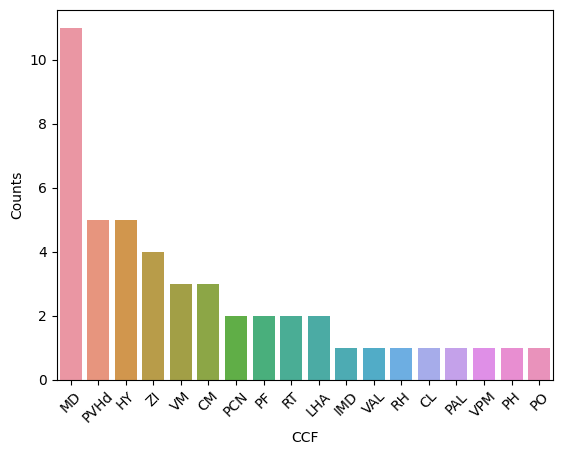

In [20]:
skel = skels_subset[100]
axon_endpoints_ccf = get_ccf_ids(ccf_atlas,skel, compartment_type=2, vertex_type="end_points")
report_distribution(axon_endpoints_ccf, percent_threshold=1)

#for bar graph
ids, cnts = np.unique(axon_endpoints_ccf, return_counts=True)
id_to_acronym = defaultdict(lambda: "NaN")
for ccf_id in list(ccf_atlas.lookup_df["id"]):
    id_to_acronym[ccf_id] = get_ccf_property(ccf_atlas, ccf_id, "acronym")
acronym_to_id = {acronym: ccf_id for ccf_id, acronym in id_to_acronym.items()}
endpoint_dataframe = pd.DataFrame({"CCF": [id_to_acronym[ccf_id] for ccf_id in ids], "Counts":cnts})
sns.barplot(endpoint_dataframe.sort_values("Counts", ascending = False).head(20),x = "CCF",y = "Counts")
plt.xticks(rotation=45);

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="3"><p><b>Exercise 3:</b> Find all neurons with somas in VAL and plot them.
    
</div>

In [21]:
target_ccf_id = 629
skels_subset = []
for i, skel in enumerate(skel_list):
    progress_bar(i + 1, len(skel_list))
    if target_ccf_id in set(get_ccf_ids(ccf_atlas, skel, compartment_type=1)):
        skels_subset.append(skel)
print("\n# Skeletons Found:", len(skels_subset))

plot = k3d.plot()
plot_graphs(skels_subset, plot)


with open(f"{data_root}/AllenCCFMesh/MouseBrainAllen3.obj") as f:
    ccf_mesh = trimesh.load(f, 'obj')


mesh = k3d.mesh(ccf_mesh.vertices*1000, ccf_mesh.faces, opacity = 0.2, color=808080)
plot += mesh
plot.display()

[==================================================] 1649/1649
# Skeletons Found: 45


Output()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="4"><p><b>Exercise 4:</b> Calculate the feature matrix of the projection targets of all these cells.
    
</div>

<Axes: >

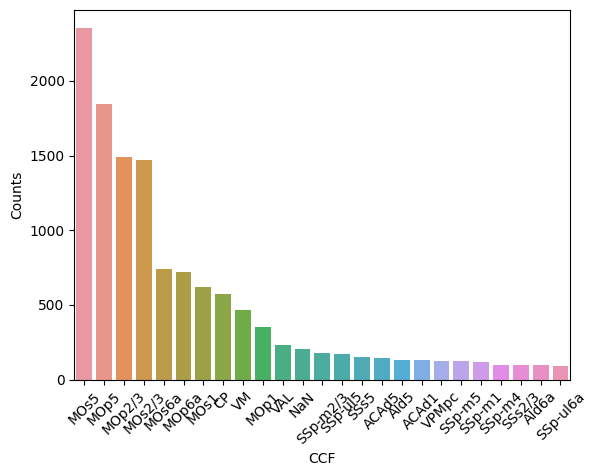

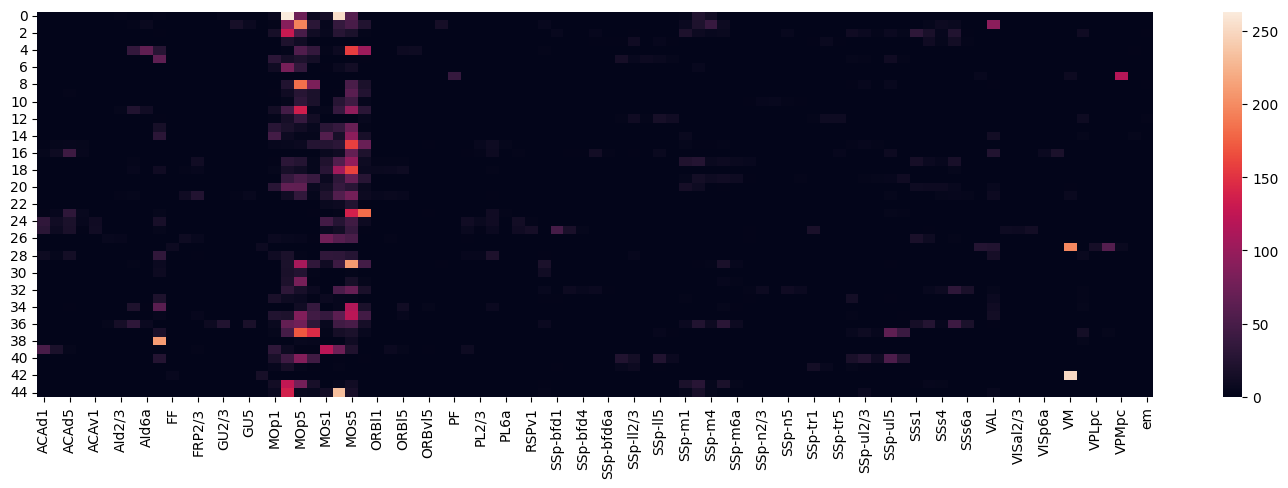

In [22]:
axon_endpoints_ccf = list()
for skel in skels_subset:
    axon_endpoints_ccf.extend(get_ccf_ids(ccf_atlas,skel, compartment_type=2, vertex_type="end_points"))

axon_endpoints_ccf = [x for x in axon_endpoints_ccf if ~np.isnan(x)]

# Then we'll plot the total axonal endpoints of our population of neurons. To reduce visual clutter, we'll only plot the top 25 most targeted CCF structures.
number_of_structures_to_plot = 25
ids, cnts = np.unique(axon_endpoints_ccf, return_counts=True)
total_endpoints = pd.DataFrame({"CCF": [id_to_acronym[ccf_id] for ccf_id in ids], "Counts":cnts})
sns.barplot(total_endpoints.sort_values("Counts", ascending = False).head(number_of_structures_to_plot),x = "CCF",y = "Counts")
plt.xticks(rotation=45);

skel_dict = {}

# Collect axon endpoints from every cell in our subset
for i, skel in enumerate(skels_subset):
    axon_endpoints_ccf = get_ccf_ids(ccf_atlas,skel, compartment_type=2, vertex_type="end_points")
    ids, cnts = np.unique(axon_endpoints_ccf, return_counts=True) # Count incidence of each terminal structure
    skel_dict[i] = dict(zip(ids,cnts)) # Bundle up CCF region IDs and counts for each cell
  
# Convert to dataframe, and remap column names from region IDs to region acronyms
df = pd.DataFrame.from_dict(skel_dict, orient='index').fillna(0)
df = df.loc[:, df.columns.isin(id_to_acronym.keys())]
df = df.rename(columns = id_to_acronym)
df = df.loc[:, df.columns != "NaN"] # remove any unrecognized CCF regions

# We can optionally trim our feature matrix to only include CCF regions that comprise a decent fraction of our total terminal endpoints across
# the population. Let's do so for now to reduce bloat in our visualizations, setting a threshold of at least 0.05% of the total endpoints.
trim_df = True
threshold = 0.0005

if trim_df:
    total_counts = df.sum(axis=0, numeric_only=True)
    cumsum = total_counts / sum(total_counts)
    keep_cols = cumsum > threshold
    df = df.loc[:,keep_cols]
 
# Now lets visualize our feature matrix. We'll sort our columns to tidy up the visualization.
sorted_columns = sorted(df.columns)
df = df[sorted_columns] # Reorder the DataFrame based on sorted column names

plt.figure(figsize=(18,5))
sns.heatmap(df.sort_index())


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="3"><p><b>Exercise 5:</b> Calculate the following features for all neurons: total axon length, total dendrite length and number of branch points. (Hint: Look at supplemental information)
    
</div>

In [23]:
ax = []; de = []; bp = []
conversion_factor = 1
for sk in skels_subset:
    #axon
    axon_inds = sk.vertex_properties['compartment']== 2 #select axon
    sk_axon = sk.apply_mask(axon_inds)
    ax.append(sk_axon.path_length()/conversion_factor) #calculate length
    
    #dendrite
    dendrite_inds = (sk.vertex_properties['compartment']==3) | (sk.vertex_properties['compartment']==4)| (sk.vertex_properties['compartment']==1) #soma is included here to connect the dendrite graphs 
    sk_dendrite = sk.apply_mask(dendrite_inds)
    de.append(sk_dendrite.path_length()/conversion_factor)
    
    #branch points
    bp.append(len(sk.branch_points))
    
     

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="3"><p><b>Exercise 6:</b> How do these features correlate against each other? How do they correlate against the number of inputs to a certain region?
    
    
</div>

<Axes: xlabel='branch points', ylabel='dendrite length'>

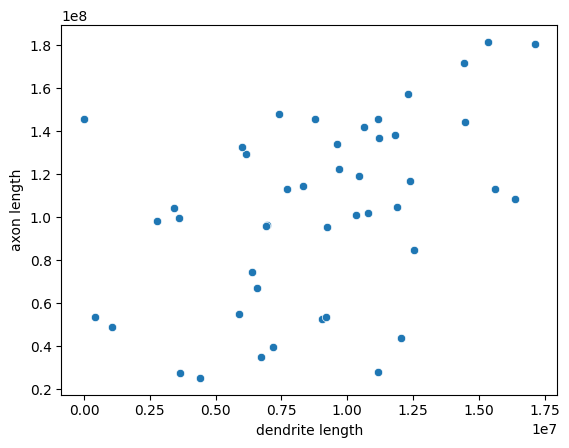

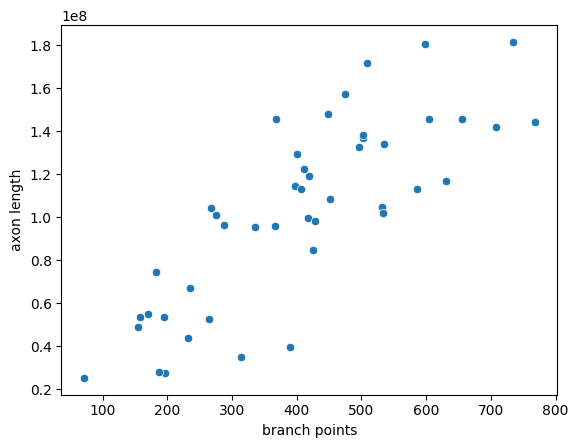

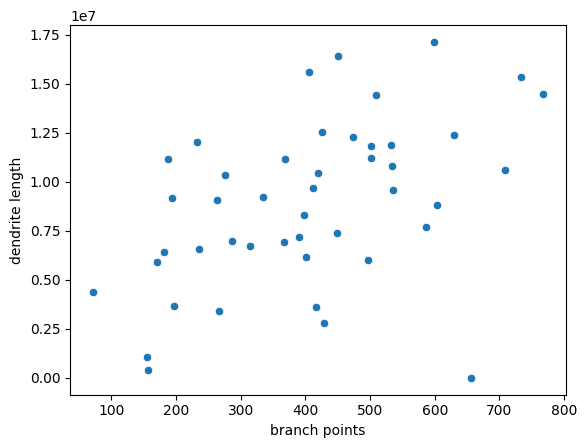

In [24]:
#To each other

plt.figure()
d = {'axon length': ax, 'dendrite length': de}
dataframe = pd.DataFrame(data=d)
sns.scatterplot(data = dataframe, y ="axon length", x= "dendrite length")

plt.figure()
d = {'axon length': ax, 'branch points': bp}
dataframe = pd.DataFrame(data=d)
sns.scatterplot(data = dataframe, y ="axon length", x= "branch points")

plt.figure()
d = {'dendrite length': de, 'branch points': bp}
dataframe = pd.DataFrame(data=d)
sns.scatterplot(data = dataframe, y ="dendrite length", x= "branch points")


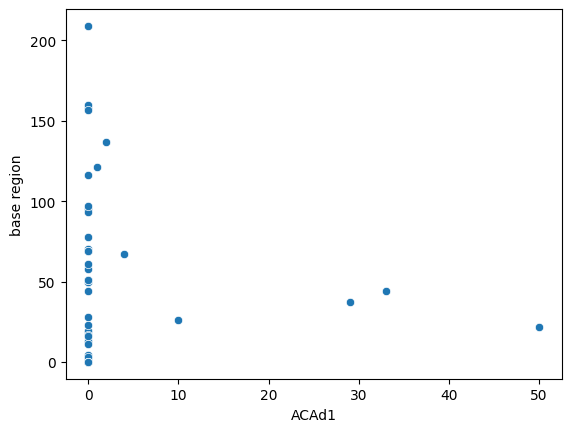

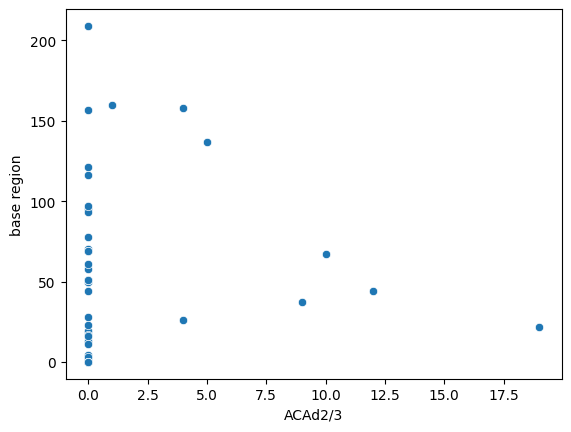

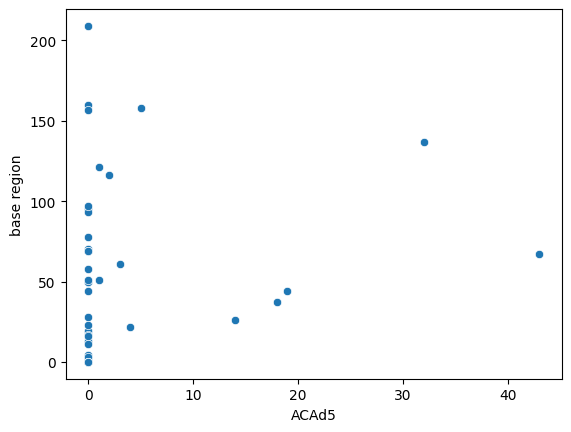

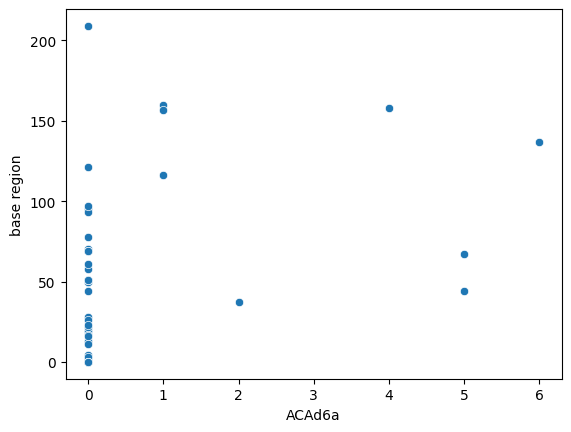

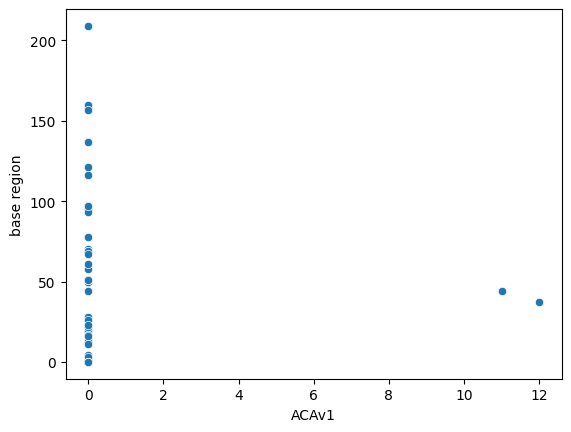

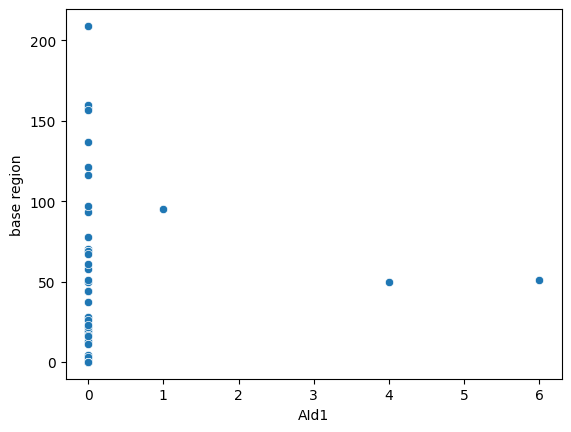

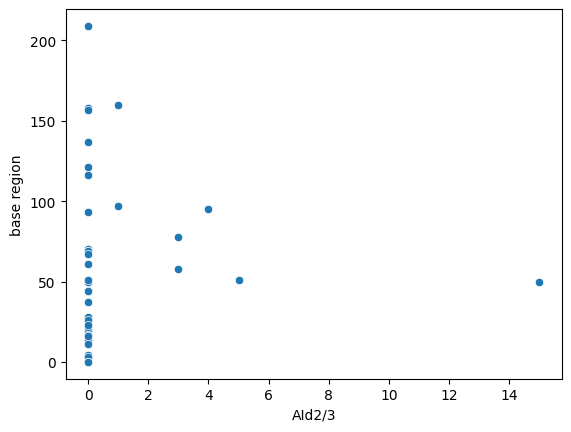

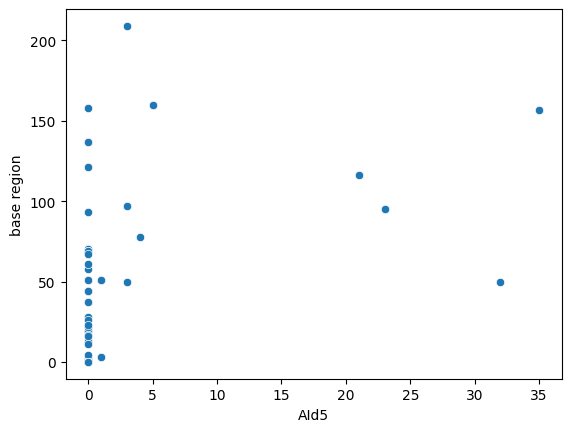

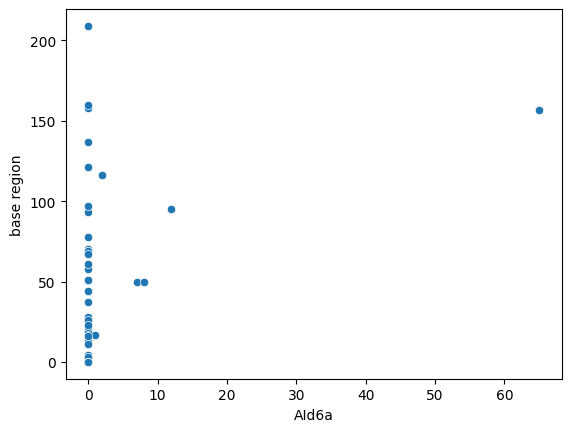

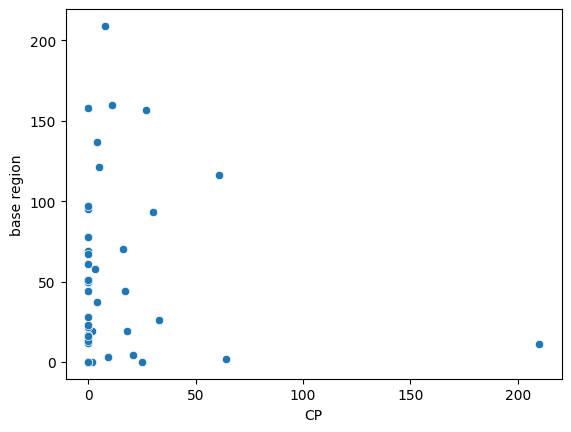

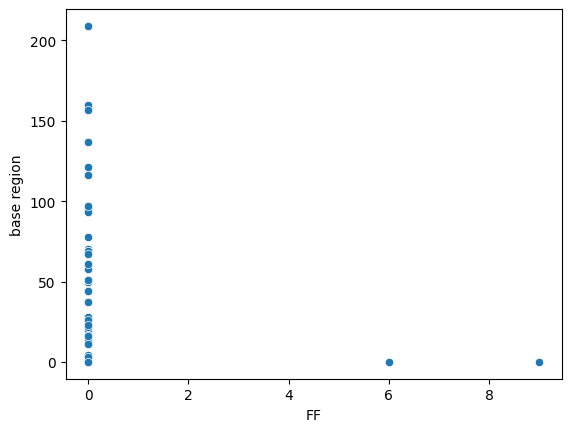

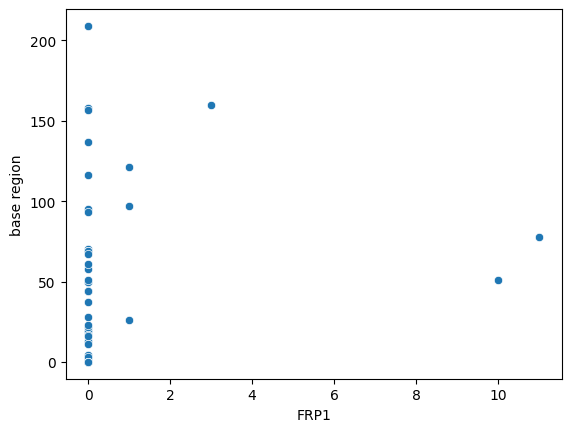

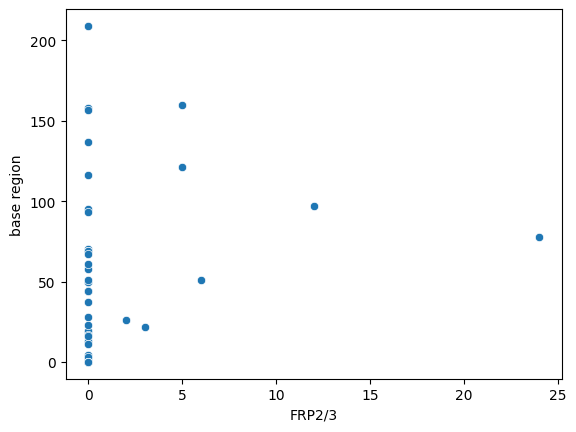

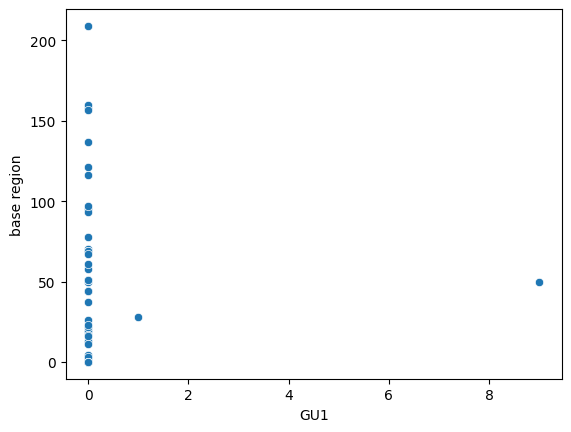

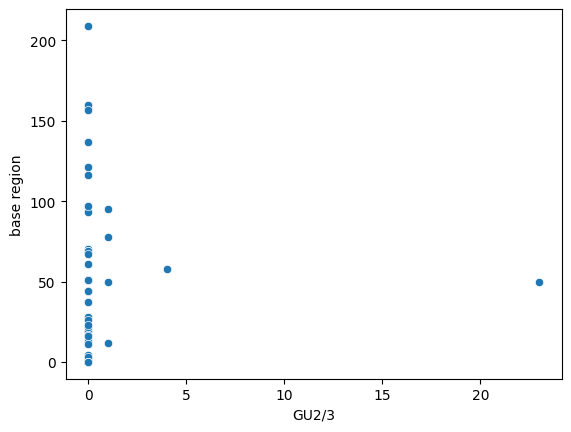

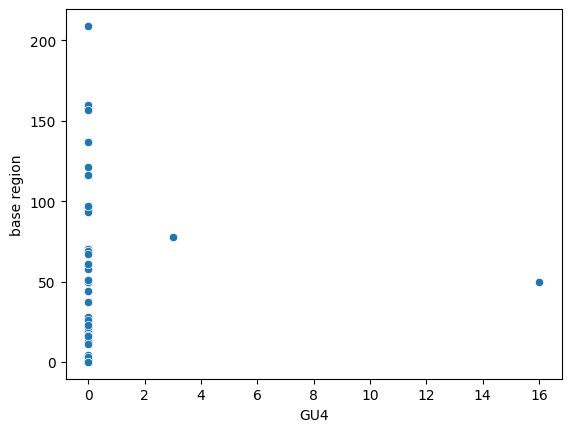

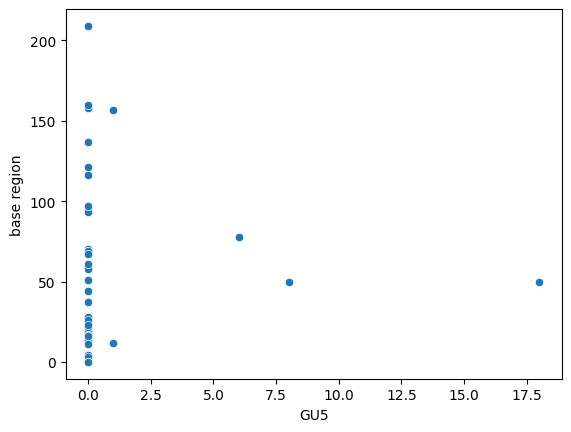

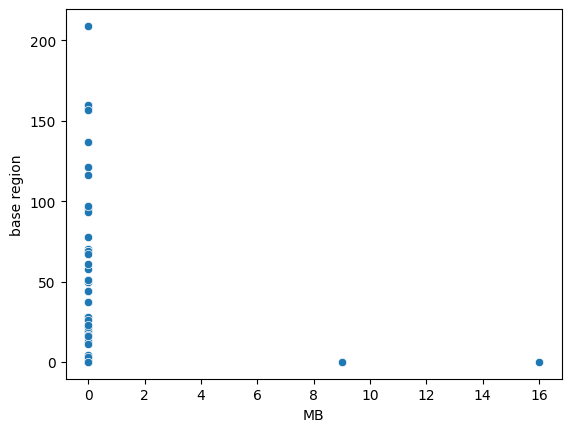

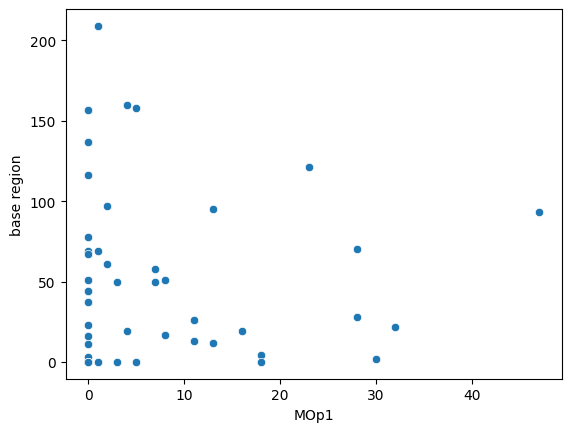

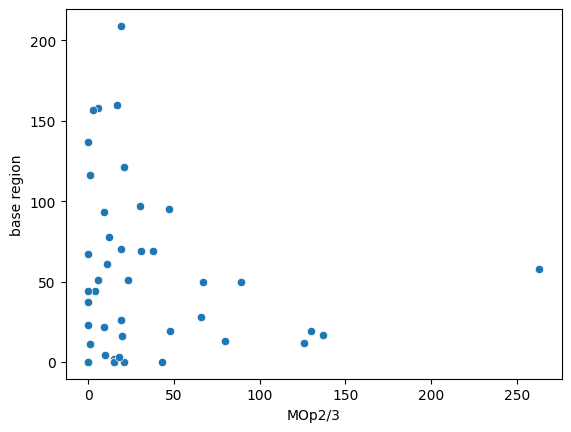

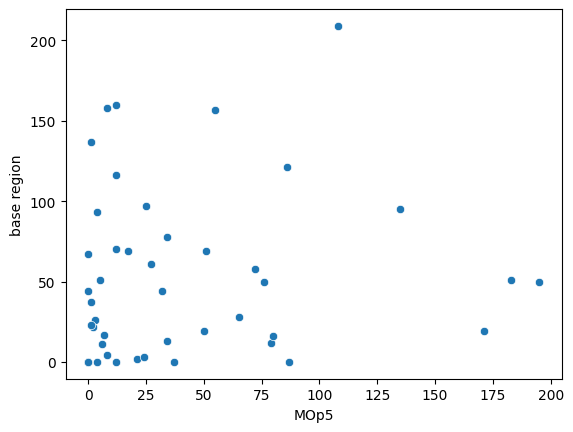

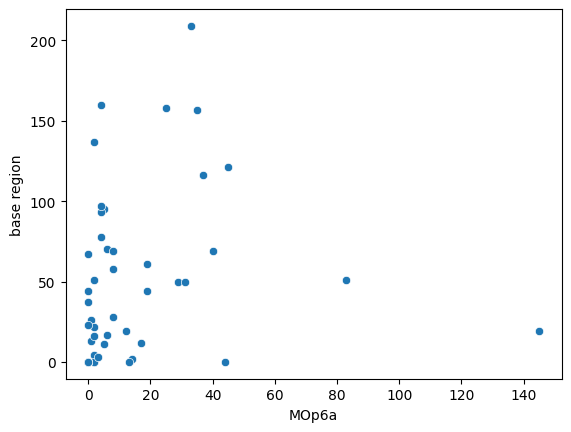

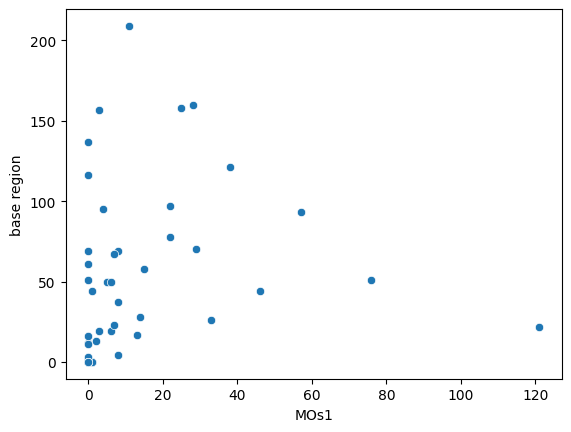

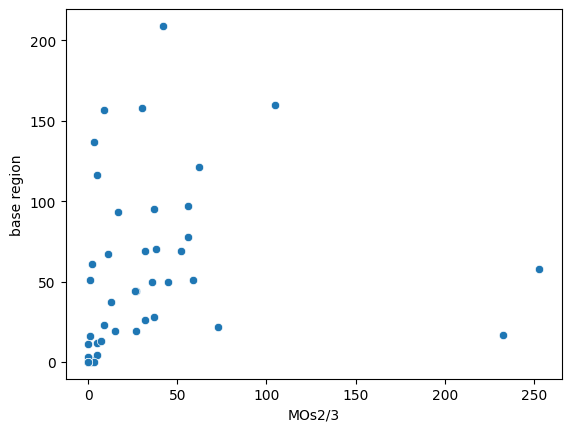

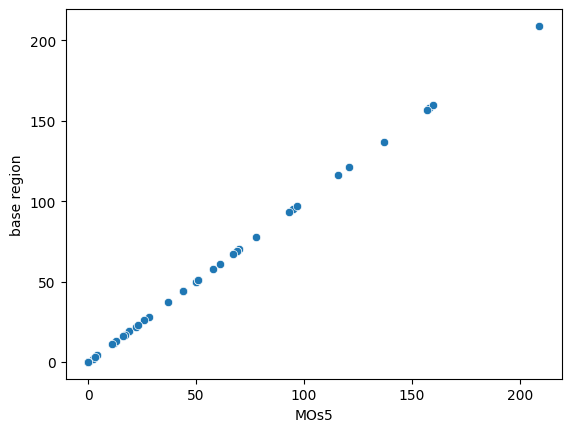

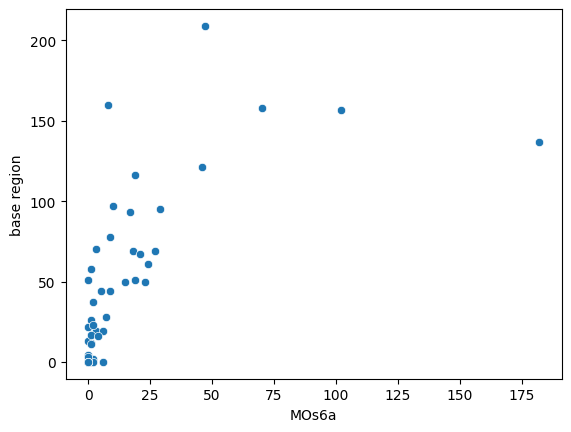

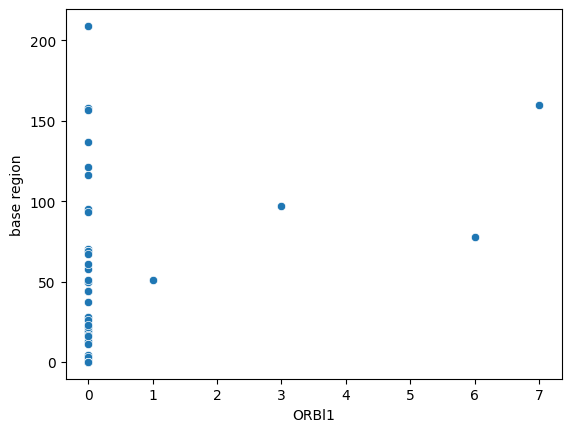

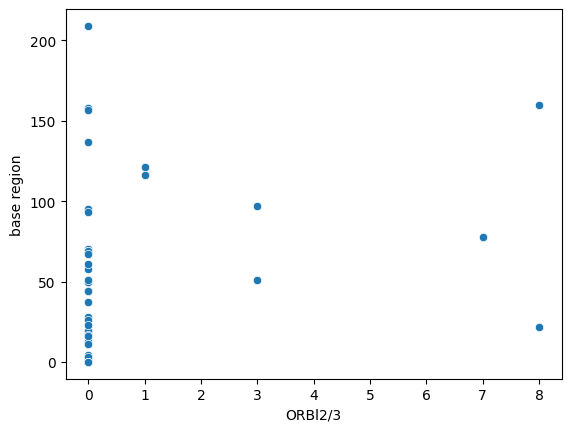

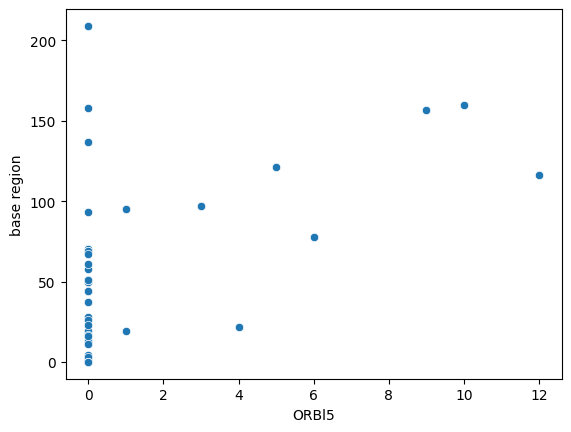

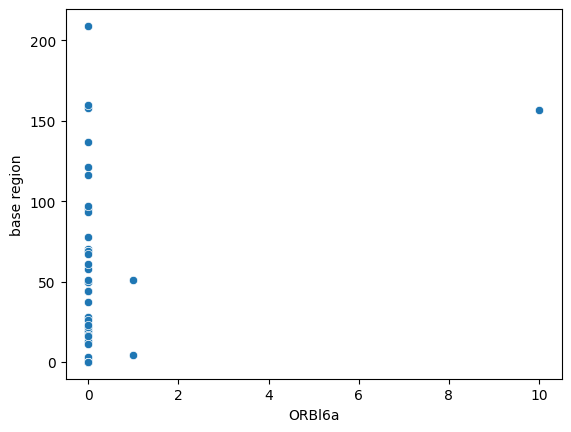

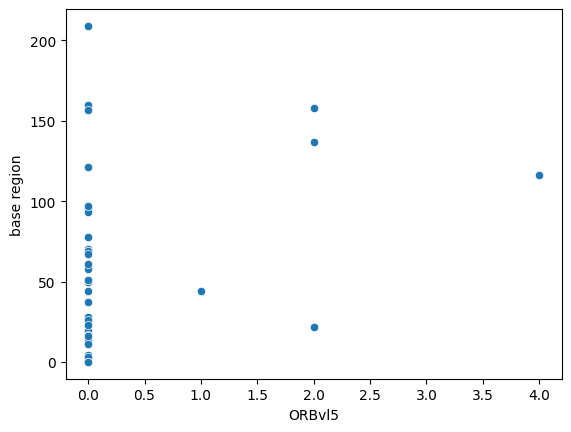

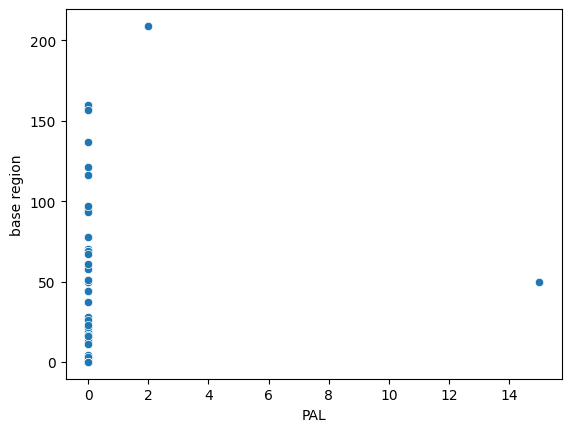

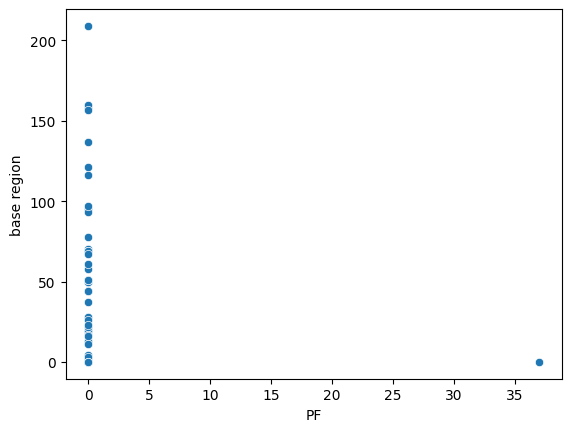

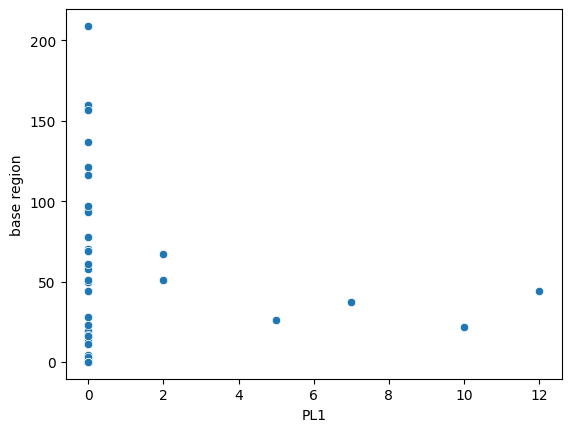

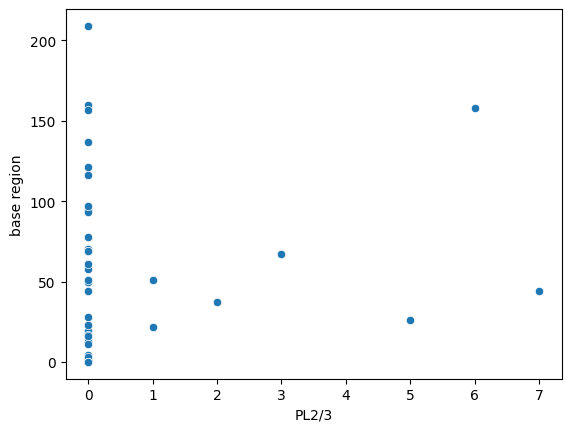

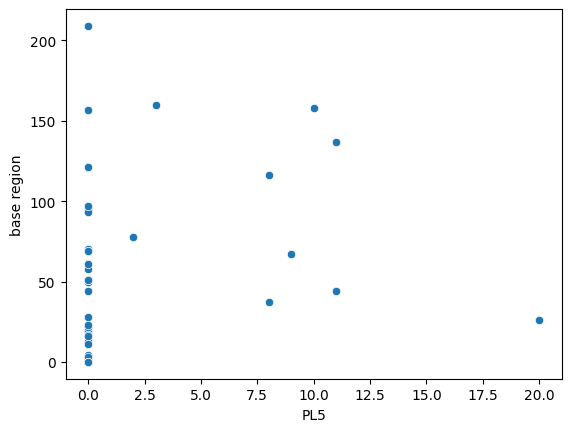

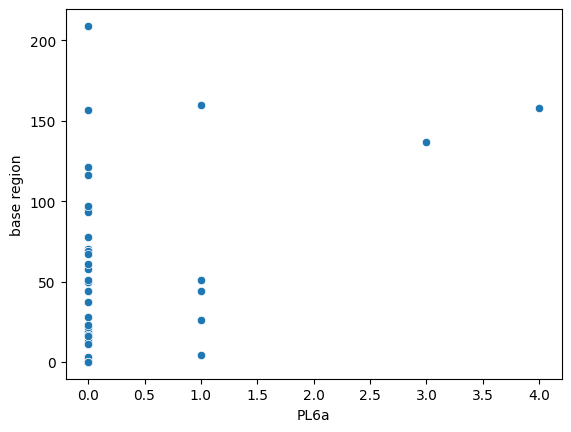

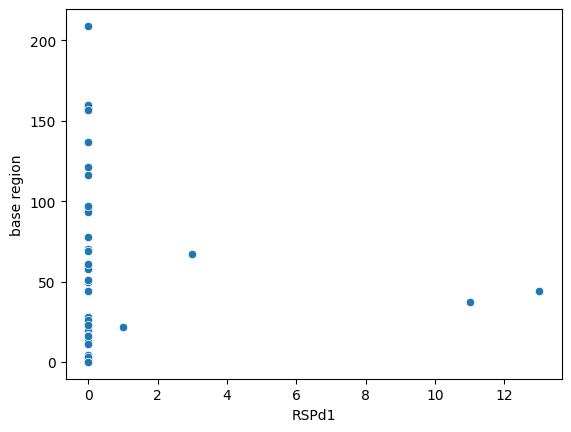

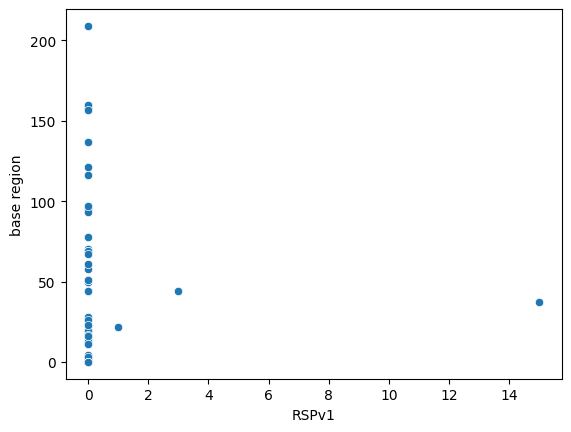

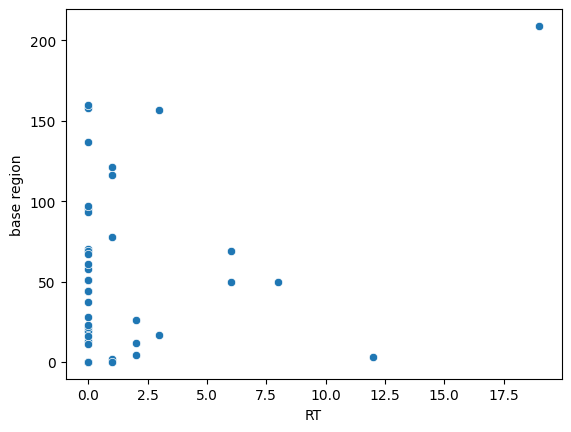

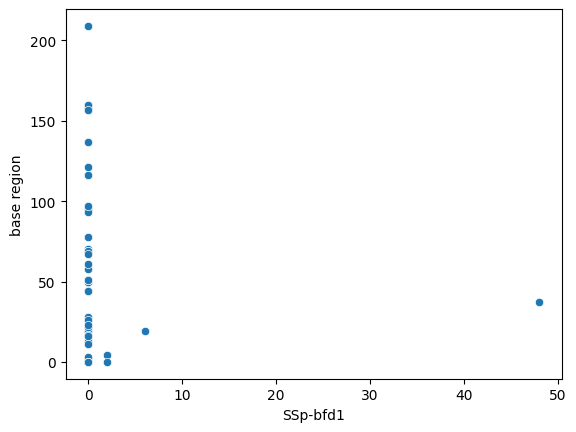

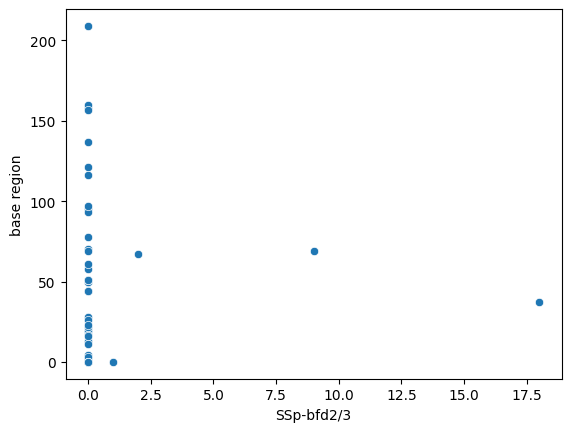

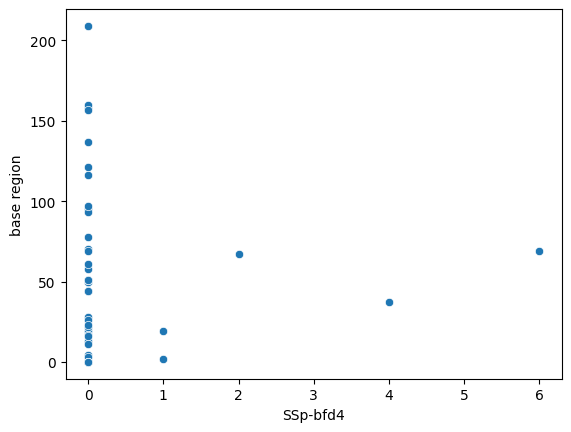

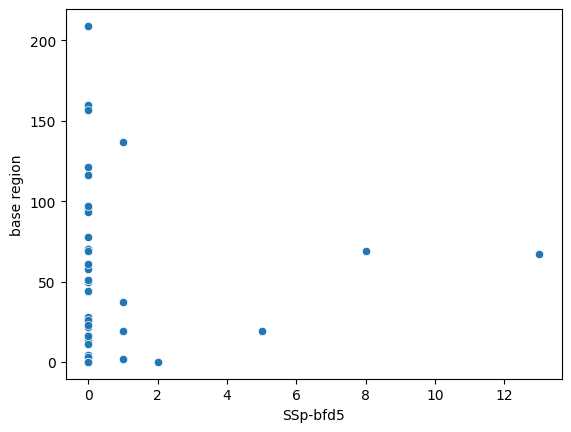

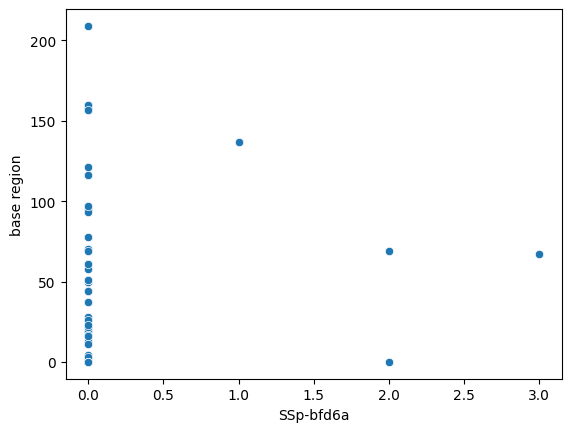

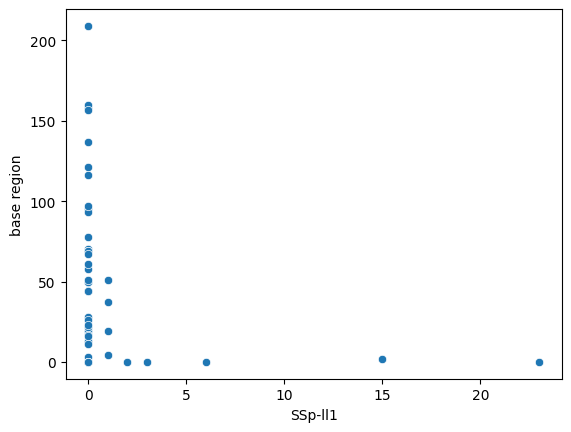

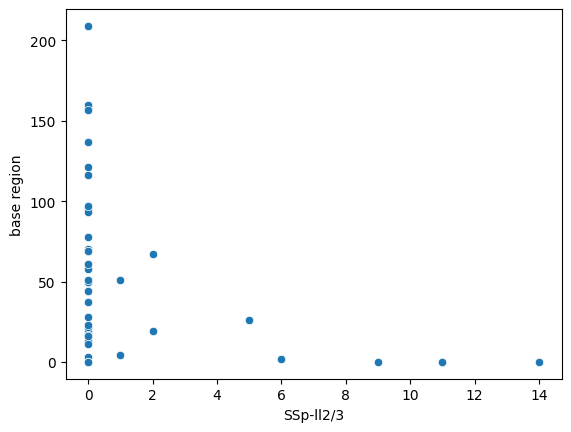

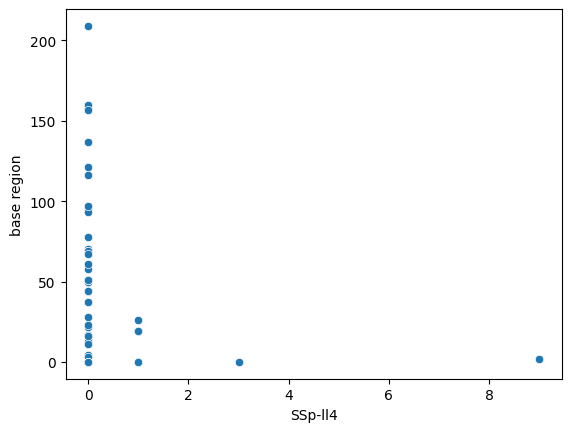

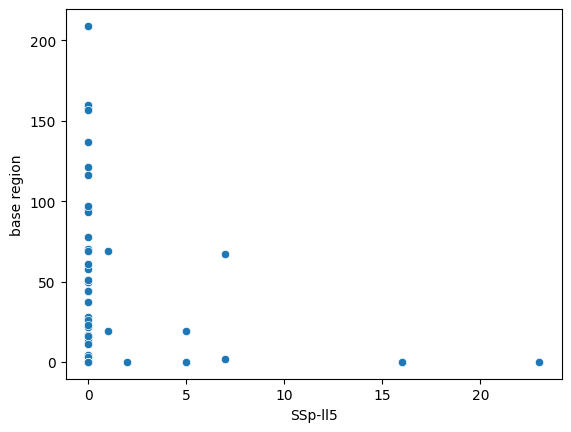

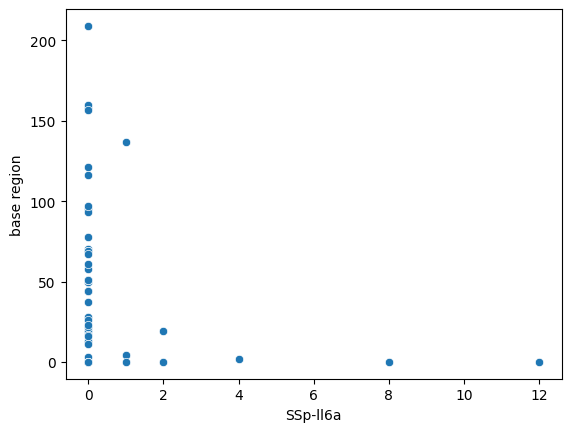

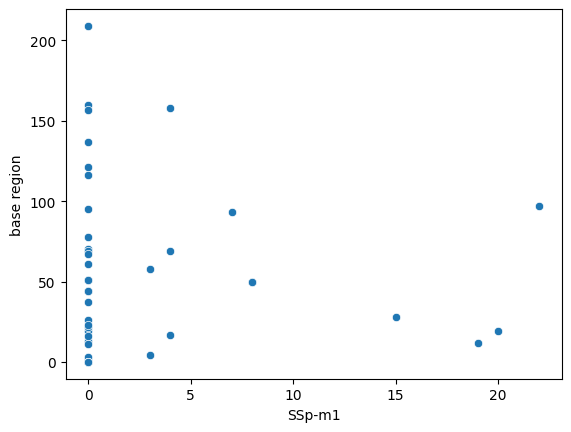

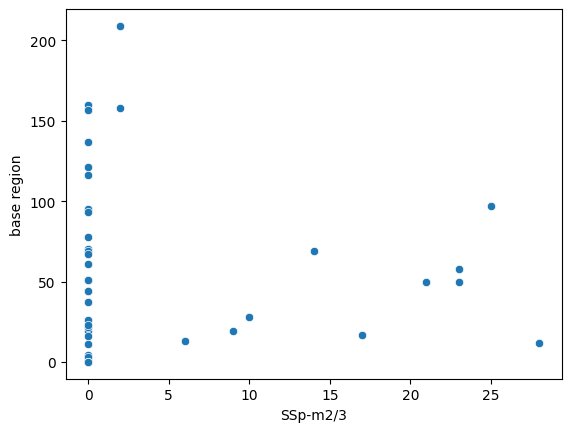

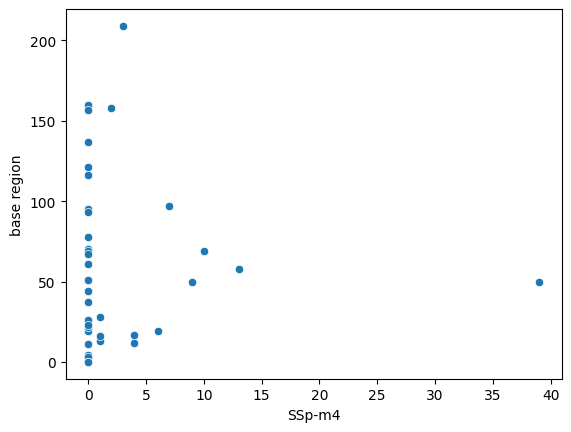

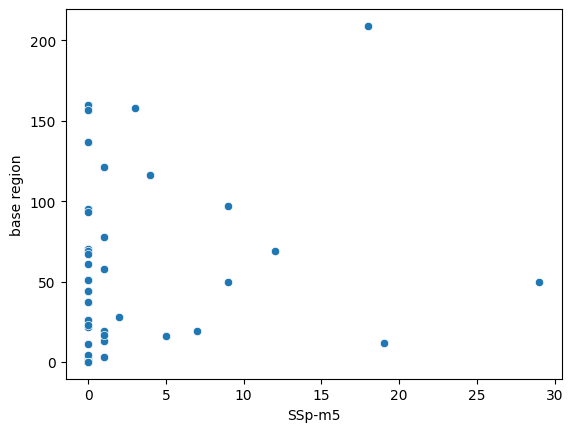

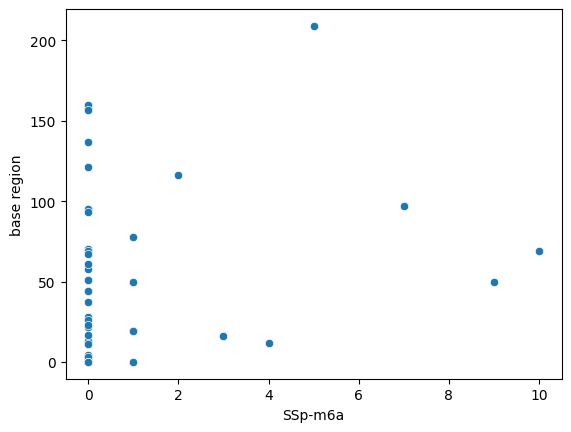

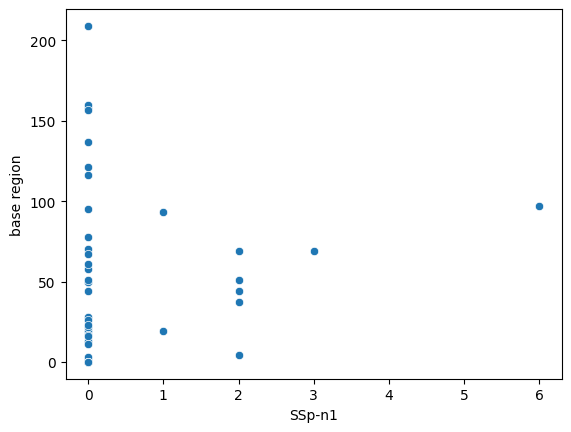

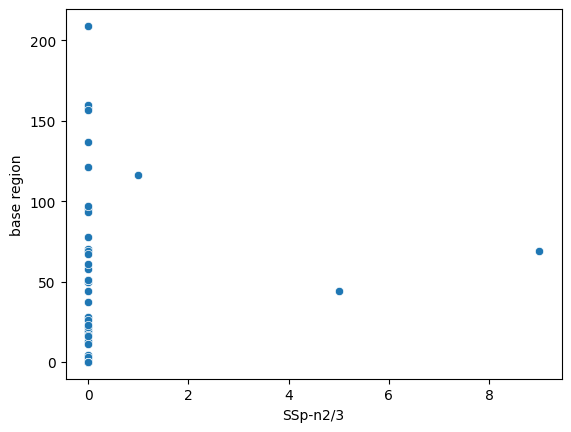

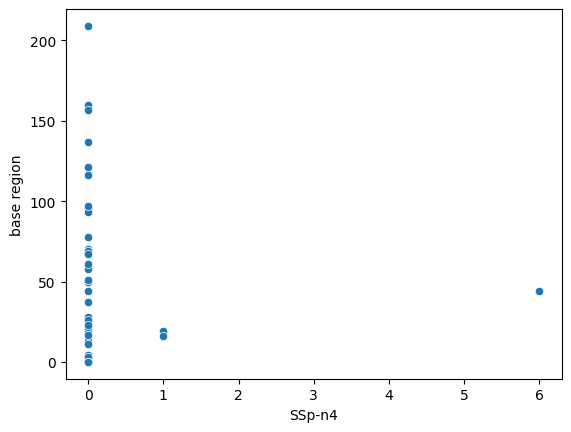

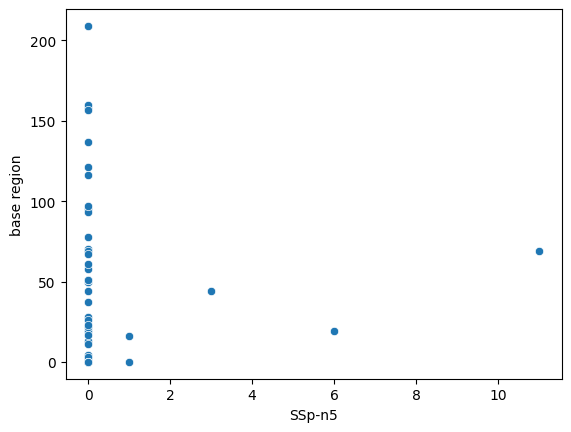

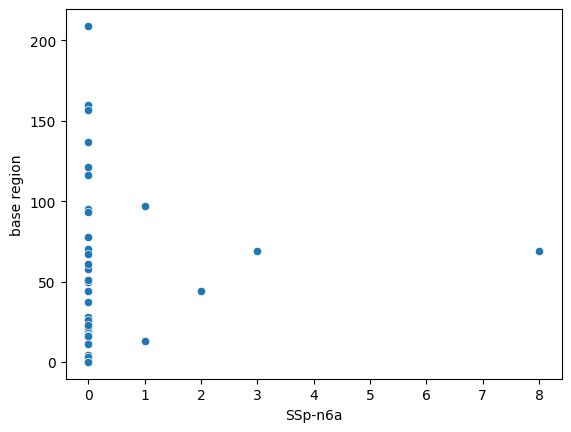

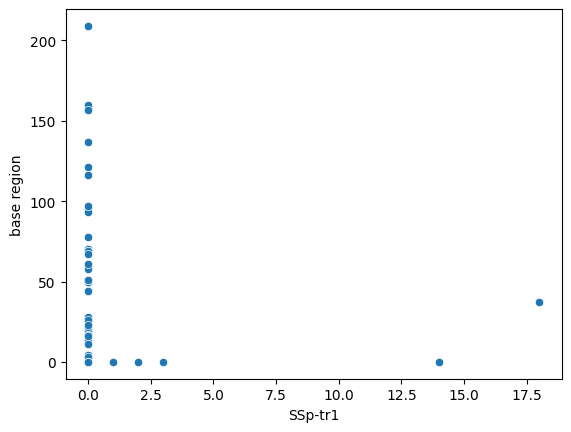

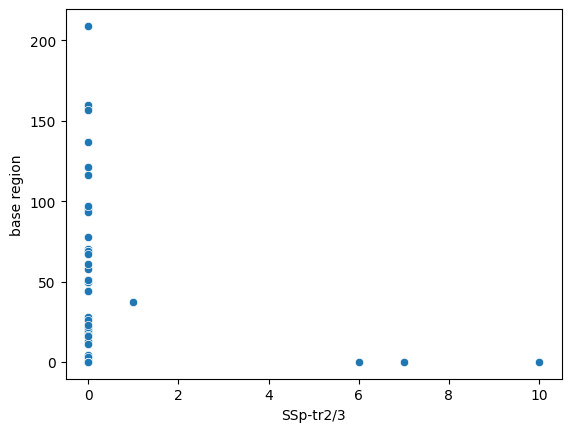

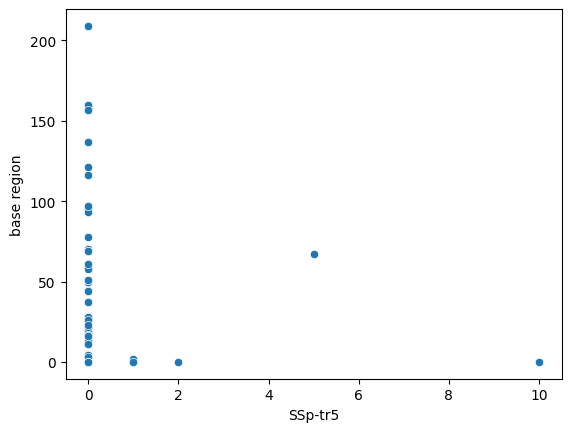

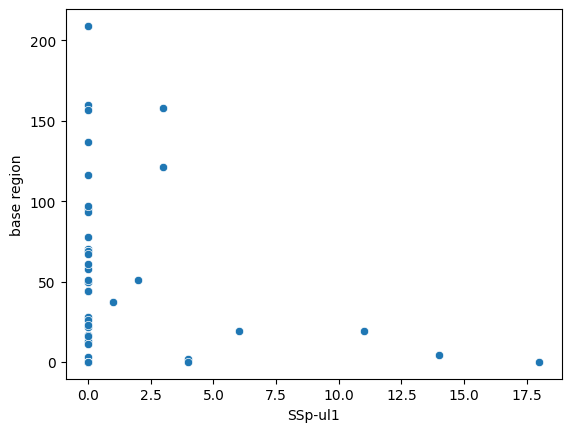

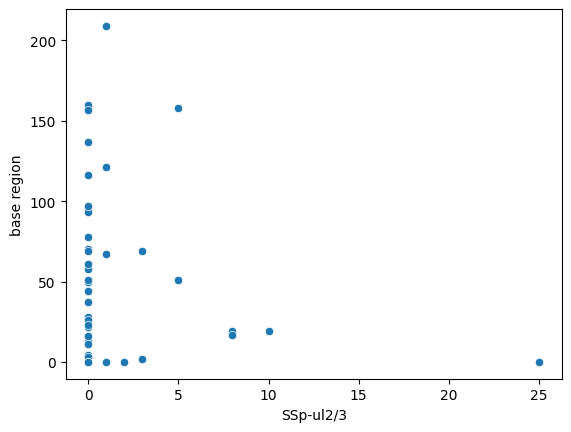

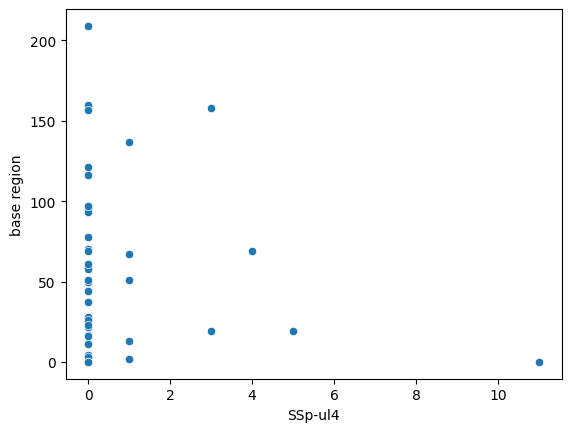

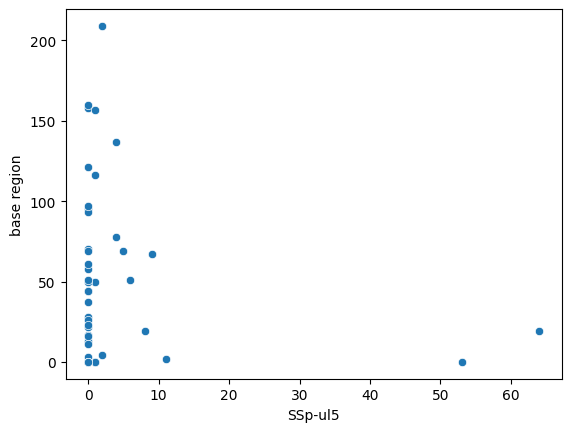

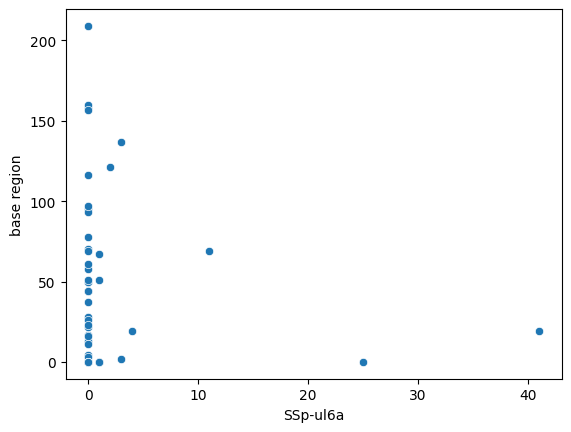

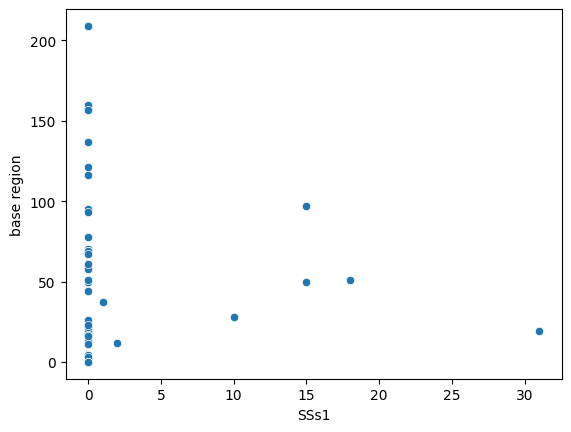

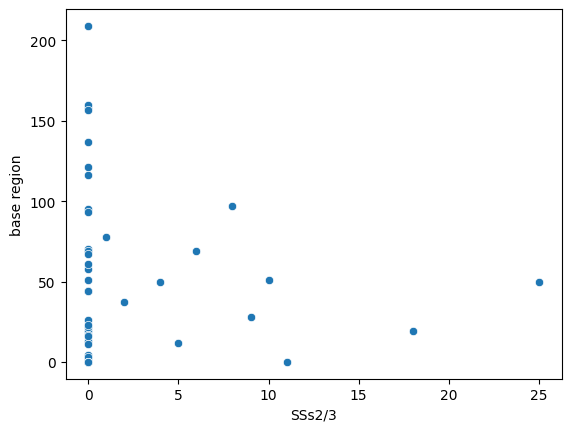

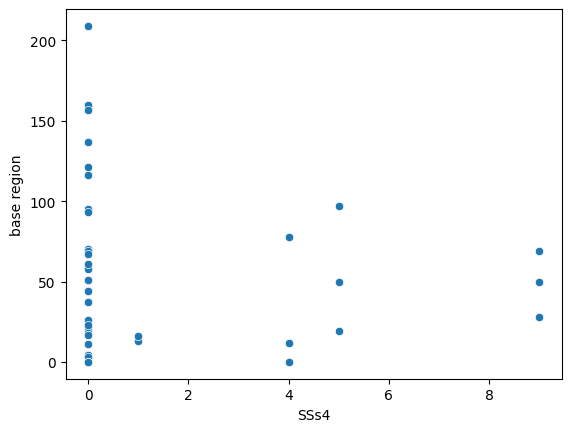

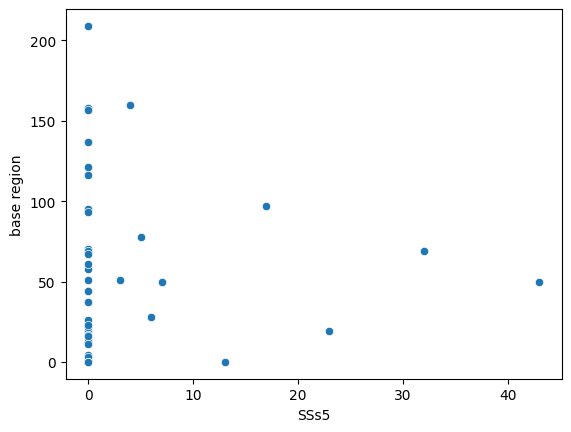

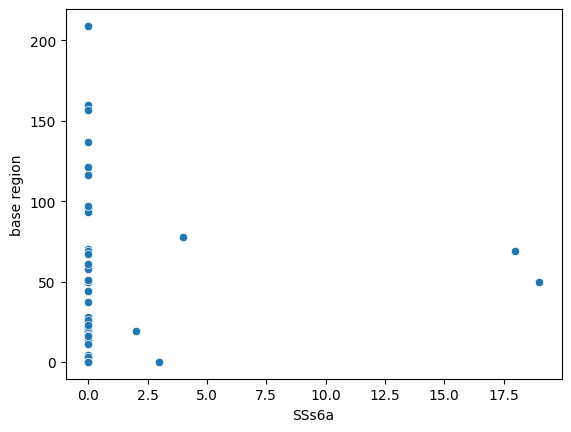

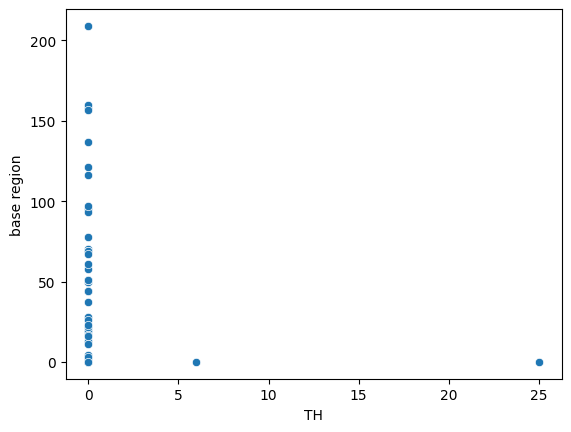

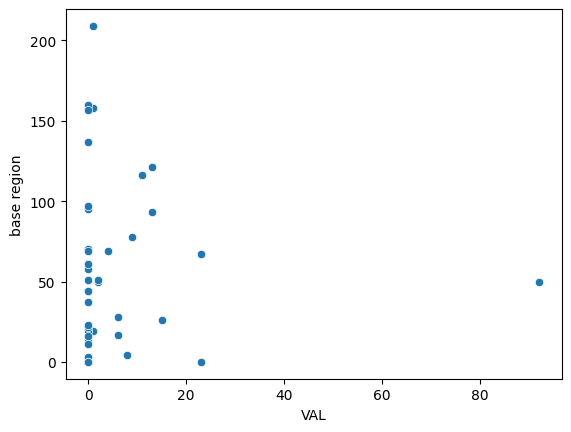

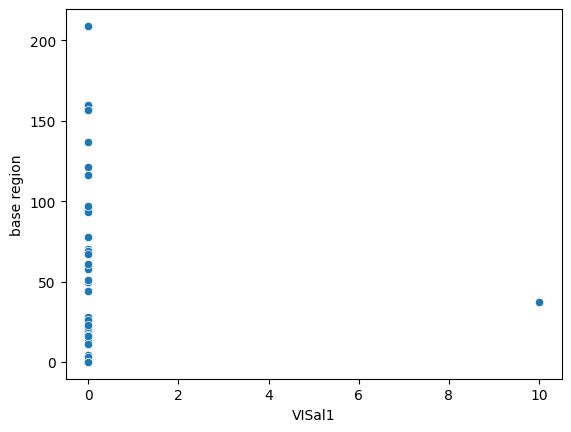

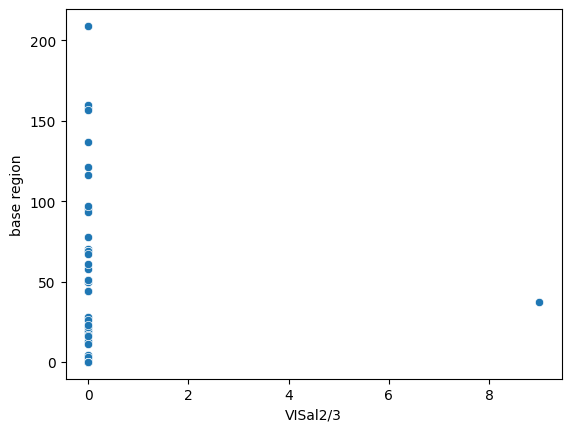

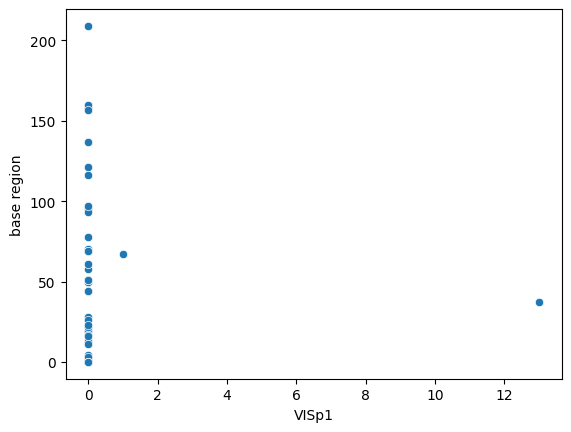

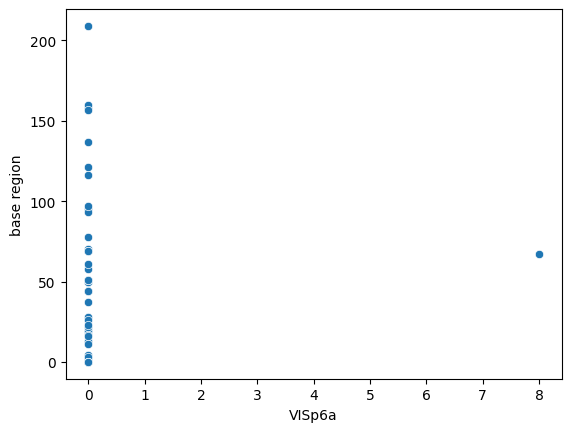

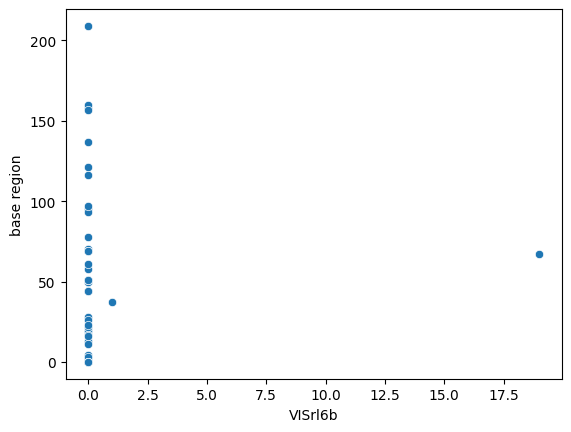

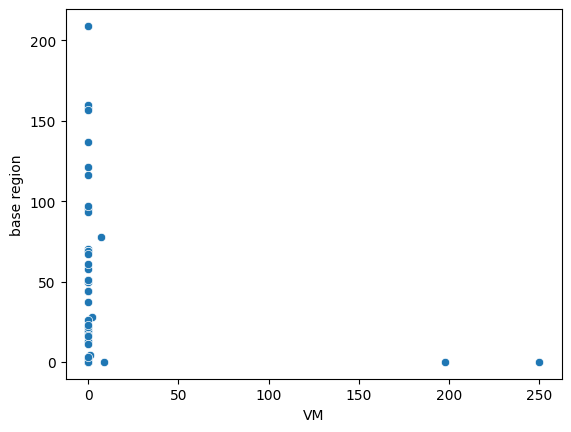

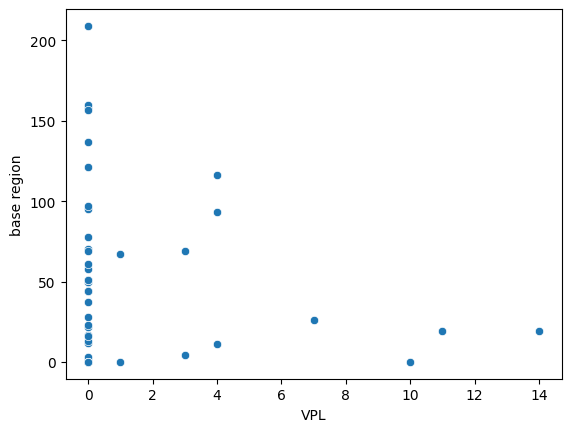

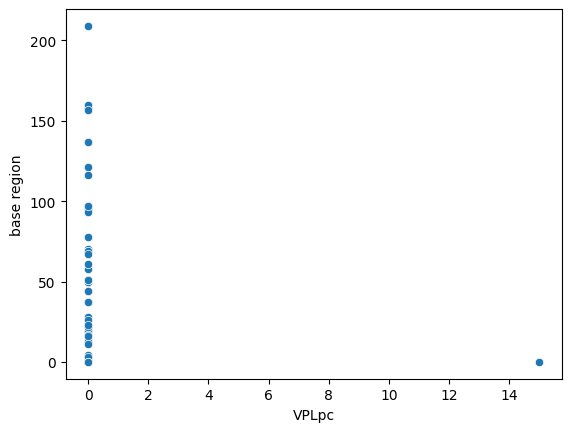

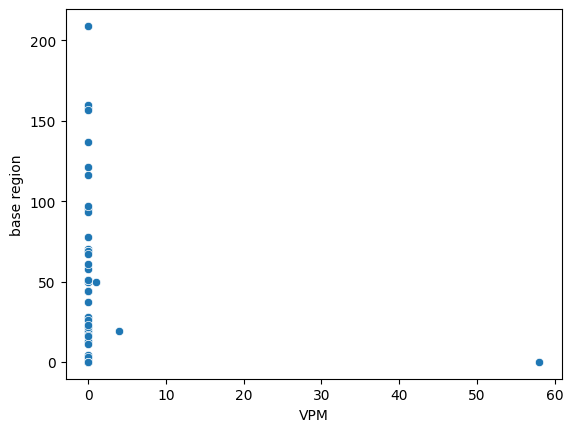

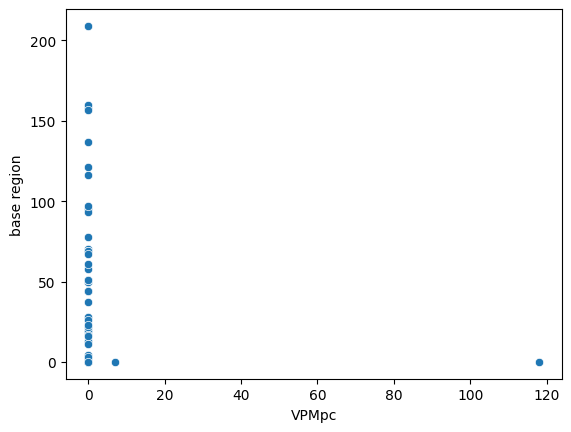

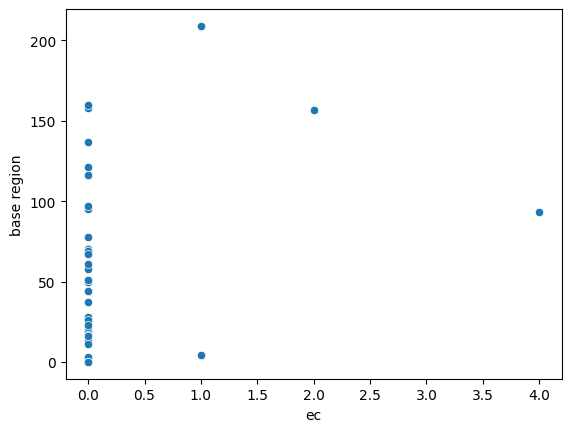

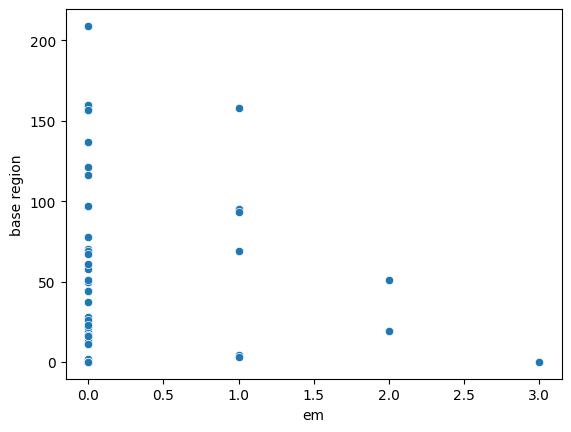

In [25]:
#Correlation of counts to # of inputs in a certain region
for k in df.keys():
    plt.figure()
    d = {'base region': df['MOs5'].values, k: df[k].values}
    dataframe = pd.DataFrame(data=d)
    sns.scatterplot(data = dataframe, y ="base region", x= k)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="3"><p><b>Extra Credit:</b> Cluster the cells with your choice of k. What do you observe? 
    
</div>

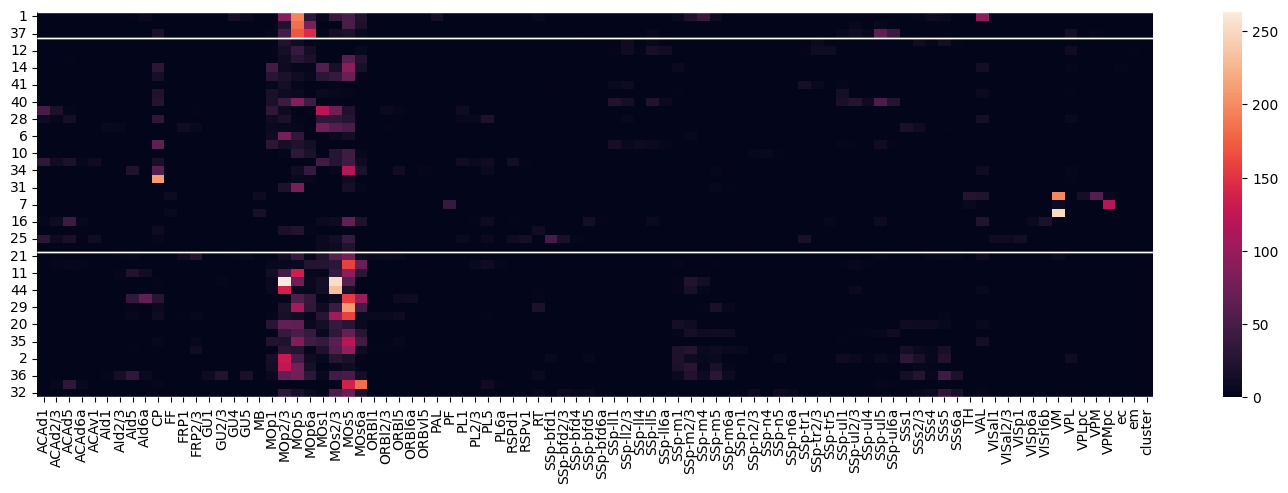

In [26]:
n_clusters = 3

# Initialize the KMeans model
kmeans = KMeans(n_clusters=n_clusters, n_init = "auto", random_state = 0)
kmeans.fit(df)

# Get the cluster labels
labels = kmeans.labels_

# We'll createa copy of our dataframe and add the cluster labels
df_clustered = df.copy()
df_clustered['cluster'] = labels

# Now lets visualize our clustering results.
df_clustered = df_clustered.sort_values("cluster") # sort by cluster label to organize plot

# Plot the heatmap
plt.figure(figsize=(18, 5))
sns.heatmap(df_clustered,  xticklabels=True)

# Outline clusters by adding lines
unique_clusters = df_clustered['cluster'].unique()
for cluster in unique_clusters:
    idx = np.where(df_clustered['cluster'] == cluster)[0]
    plt.hlines([min(idx), max(idx) + 1], *plt.xlim(), colors='white', linewidth=1)

In [27]:
cluster_to_plot = 0
plot = k3d.plot()

sks = []
for skel in [skels_subset[i] for i in np.where(df_clustered["cluster"] == cluster_to_plot)[0]]:
    sks.append(skel)
plot_graphs(sks, plot, color=808088)


mesh = k3d.mesh(ccf_mesh.vertices*1000, ccf_mesh.faces, opacity = 0.2, color=808080)
plot += mesh
plot.display()

Output()

In [28]:
cluster_to_plot = 1
plot = k3d.plot()

sks = []
for skel in [skels_subset[i] for i in np.where(df_clustered["cluster"] == cluster_to_plot)[0]]:
    sks.append(skel)
plot_graphs(sks, plot, color=900000)


mesh = k3d.mesh(ccf_mesh.vertices*1000, ccf_mesh.faces, opacity = 0.2, color=808080)
plot += mesh
plot.display()

Output()

In [29]:
cluster_to_plot = 2
plot = k3d.plot()

sks = []
for skel in [skels_subset[i] for i in np.where(df_clustered["cluster"] == cluster_to_plot)[0]]:
    sks.append(skel)
plot_graphs(sks, plot, color=999000)


mesh = k3d.mesh(ccf_mesh.vertices*1000, ccf_mesh.faces, opacity = 0.2, color=808080)
plot += mesh
plot.display()

Output()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4>Extra Exercises </h4>
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<font size="4"><p><b>Task 1.1:</b>  Find the most fine-grained brain region contained in the CCF (i.e. region at the largest depth).
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<font size="4"><p><b>Task 1.2:</b>  How many brain regions are at a depth=0, 1,..., n where n is the depth value from Task 1.1.

</div>